In [1]:
# !pip install pandas
# !pip install seaborn
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

## 0. 라이브러리 불러오기

In [2]:
import os
import cv2
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from spectral import open_image
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

warnings.filterwarnings(action='ignore')


## 1. 데이터셋 불러오기

In [3]:
def load_hyperspectral_data(hyperspectral_folder, label_folder, num_files=10):
    """ Load hyperspectral data from HDR and RAW files, flatten, and concatenate. """
    X, y = [], []
    file_list = sorted([f for f in os.listdir(label_folder) if f.endswith('.png')])[:num_files]
    
    for label_file in file_list:
        base_name = os.path.splitext(label_file)[0]
        hdr_path = os.path.join(hyperspectral_folder, base_name + '.hdr')
        raw_path = hdr_path.replace('.hdr', '.raw')
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(hdr_path):
            continue
        
        # Load hyperspectral cube
        img = open_image(hdr_path)
        hyperspectral_cube = img.load()
        flattened_cube = hyperspectral_cube.reshape(-1, hyperspectral_cube.shape[-1])  # Shape: (96000, 256)
        
        # Load corresponding label image
        label_img = Image.open(label_path).convert('L')
        label_array = np.array(label_img).flatten()
        label_array = np.where(label_array < 10, 0, np.where(label_array > 240, 2, 1))
        
        X.append(flattened_cube)
        y.append(label_array)
    
    # Concatenate all images together
    X = np.vstack(X)  # Shape: (num_files * 96000, 256)
    y = np.hstack(y)  # Shape: (num_files * 96000, 1)
    return X, y

# Set the dataset folder paths
hyperspectral_folder = r"Z:/5. 연구소/2. 국책과제/2023-기술혁신-시장대응형(스마트APC)/참고자료/2024 자체 구축 데이터셋/배/241203 배 외부결함/splited"
label_folder = r"Z:/5. 연구소/2. 국책과제/2023-기술혁신-시장대응형(스마트APC)/참고자료/2024 자체 구축 데이터셋/배/241203 배 외부결함/splited_label"
X, y = load_hyperspectral_data(hyperspectral_folder, label_folder, num_files=4)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## 2. 전처리 함수 정의

In [4]:
def apply_snv(data):
    """ Apply Standard Normal Variate (SNV) Preprocessing """
    return (data - np.mean(data, axis=1, keepdims=True)) / np.std(data, axis=1, keepdims=True)

def apply_savgol_filter(data, window_size=5, polyorder=2):
    """ Apply Savitzky-Golay filter for smoothing """
    from scipy.signal import savgol_filter
    return savgol_filter(data, window_length=window_size, polyorder=polyorder, axis=1)

def apply_differencing(data):
    """ Apply Spectral Differencing """
    return np.diff(data, axis=1)


## 4. 실험 - 전처리와 차분을 경우별로 적용

In [ ]:
experiments = []
settings = [(False, False, False), 
            (False, False, True), 
            (False, True, False), 
            (False, True, True),
            (True, False, False), 
            (True, False, True), 
            (True, True, False), 
            (True, True, True),
            ]

for snv, savgol, diff in settings:
    X_train_proc, X_test_proc = X_train.copy(), X_test.copy()
    if savgol:
        X_train_proc = apply_savgol_filter(X_train_proc)
        X_test_proc = apply_savgol_filter(X_test_proc)
    if snv:
        X_train_proc = apply_snv(X_train_proc)
        X_test_proc = apply_snv(X_test_proc)
    if diff:
        X_train_proc = apply_differencing(X_train_proc)
        X_test_proc = apply_differencing(X_test_proc)

    model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    # model.fit(X_train_proc, y_train)
    # joblib.dump(model,f'./weights/{int(snv)}_{int(savgol)}_{int(diff)}_pear_preprocessing_test_model.pkl')
    model = joblib.load(f'./weights/{int(snv)}_{int(savgol)}_{int(diff)}_pear_preprocessing_test_model.pkl')
    y_pred = model.predict(X_test_proc)
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, model.predict_proba(X_test_proc), multi_class='ovr') if hasattr(model, 'predict_proba') else None
    accuracy = accuracy_score(y_test, y_pred)
    experiments.append([snv, savgol, diff, accuracy, f1, auc])

# Convert results to DataFrame
exp_results_df = pd.DataFrame(experiments, columns=['SNV', 'Savgol', 'Differencing', 'Accuracy', 'F1-score', 'roc-auc-score'])
print(exp_results_df.to_string(index=False))



  File "c:\Users\Jaehyuk\anaconda3\envs\HSI\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\Jaehyuk\anaconda3\envs\HSI\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Jaehyuk\anaconda3\envs\HSI\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Jaehyuk\anaconda3\envs\HSI\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


  SNV  Savgol  Differencing  Accuracy  F1-score  roc-auc-score
False   False         False  0.993499  0.993446       0.992136
False   False          True  0.990721  0.990086       0.967633
False    True         False  0.993422  0.993369       0.992164
False    True          True  0.993345  0.993214       0.984939
 True   False         False  0.993789  0.993814       0.991957
 True   False          True  0.987365  0.986597       0.957004
 True    True         False  0.993943  0.993933       0.991971
 True    True          True  0.990664  0.990541       0.982433


In [5]:
def normalize_band(band):
    """Normalize a band to the range 0-255."""
    band_min, band_max = np.min(band), np.max(band)
    return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)

def generate_rgb_image(hyperspectral_data):
    """Generate an RGB image using specific bands."""
    r_band = normalize_band(hyperspectral_data[:, :, 100])
    g_band = normalize_band(hyperspectral_data[:, :, 150])
    b_band = normalize_band(hyperspectral_data[:, :, 200])
    return np.squeeze(np.stack([r_band, g_band, b_band], axis=-1))

Hsi20241119201229_0002_1


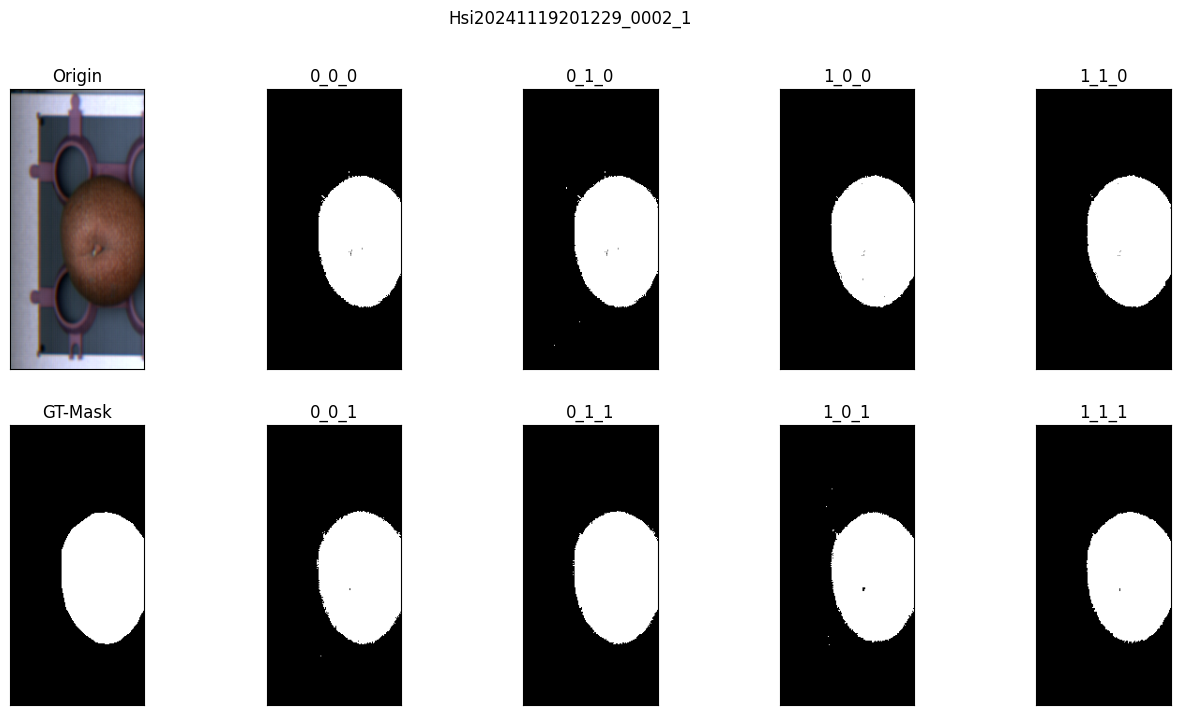

Hsi20241119201229_0002_2


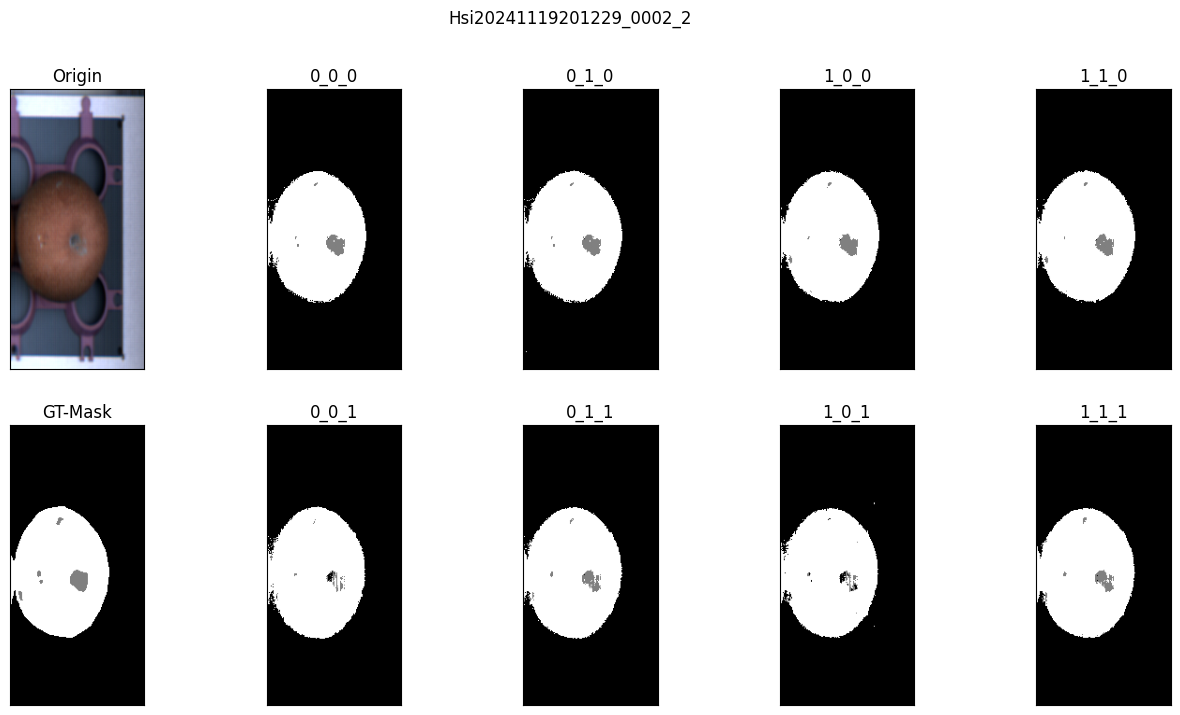

Hsi20241119201913_0003_1


In [ ]:
file_list = sorted([f for f in os.listdir(label_folder) if f.endswith('.png')])[:4]

for label_file in file_list:
    base_name = os.path.splitext(label_file)[0]
    hdr_path = os.path.join(hyperspectral_folder, base_name + '.hdr')
    raw_path = hdr_path.replace('.hdr', '.raw')
    label_path = os.path.join(label_folder, label_file)
    
    if not os.path.exists(hdr_path):
        continue
    
    # Load hyperspectral cube
    img = open_image(hdr_path)
    hyperspectral_cube = img.load()
    flattened_cube = hyperspectral_cube.reshape(-1, hyperspectral_cube.shape[-1])  # Shape: (96000, 256)
    
    # Load corresponding label image
    label_img = Image.open(label_path).convert('L')

    print(base_name)

    plt.figure(figsize=(16, 8))
    plt.suptitle(base_name)

    plt.subplot(2, 5, 1)
    plt.title("Origin")
    rgb_image = generate_rgb_image(hyperspectral_cube)
    plt.imshow(rgb_image)

    plt.subplot(2, 5, 6)
    plt.title("GT-Mask")
    label_image = label_img.copy()
    plt.imshow(label_image, cmap='gray')

    plt.subplot(2, 5, 2)
    plt.title("0_0_0")
    model = joblib.load('./weights/0_0_0_pear_preprocessing_test_model.pkl')
    pred_image = model.predict(flattened_cube).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 3)
    plt.title("0_1_0")
    model = joblib.load('./weights/0_1_0_pear_preprocessing_test_model.pkl')
    pred_image = model.predict(apply_savgol_filter(flattened_cube)).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 4)
    plt.title("1_0_0")
    model = joblib.load('./weights/1_0_0_pear_preprocessing_test_model.pkl')
    pred_image = model.predict(apply_snv(flattened_cube)).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 5)
    plt.title("1_1_0")
    model = joblib.load('./weights/1_1_0_pear_preprocessing_test_model.pkl')
    pred_image = model.predict(apply_snv(apply_savgol_filter(flattened_cube))).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 7)
    plt.title("0_0_1")
    model = joblib.load('./weights/0_0_1_pear_preprocessing_test_model.pkl')
    pred_image = model.predict(apply_differencing(flattened_cube)).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 8)
    plt.title("0_1_1")
    model = joblib.load('./weights/0_1_1_pear_preprocessing_test_model.pkl')
    pred_image = model.predict(apply_differencing(apply_savgol_filter(flattened_cube))).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 9)
    plt.title("1_0_1")
    model = joblib.load('./weights/1_0_1_pear_preprocessing_test_model.pkl')
    pred_image = model.predict(apply_differencing(apply_snv(flattened_cube))).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 10)
    plt.title("1_1_1")
    model = joblib.load('./weights/1_1_1_pear_preprocessing_test_model.pkl')
    pred_image = model.predict(apply_differencing(apply_snv(apply_savgol_filter(flattened_cube)))).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    # 모든 subplot의 눈금을 제거
    for ax in plt.gcf().get_axes():
        ax.set_xticks([])
        ax.set_yticks([])

    plt.savefig(f'./OUTPUT/pear/preprocessing_test/{base_name}.png')
    plt.show()

## 5. 실험 - 머신러닝 모델 종류별 적용

In [ ]:
# best_setting = exp_results_df.sort_values(by='F1-score', ascending=False).iloc[0]
best_setting = exp_results_df.sort_values(by='roc-auc-score', ascending=False).iloc[0]
# print("Best Setting:\n", best_setting)

print("Ascening by Accuracy:\n")
print(exp_results_df.sort_values(by='Accuracy', ascending=False).to_string(index=False))
print("\nAscening by F1 score:\n")
print(exp_results_df.sort_values(by='F1-score', ascending=False).to_string(index=False))
print("\nAscening by ROC-AUC score:\n")
print(exp_results_df.sort_values(by='roc-auc-score', ascending=False).to_string(index=False))

In [8]:
X_train_proc, X_test_proc = X_train.copy(), X_test.copy()

# if best_setting['SNV']:
#     X_train_proc = apply_snv(X_train_proc)
#     X_test_proc = apply_snv(X_test_proc)
# if best_setting['Savgol']:
#     X_train_proc = apply_savgol_filter(X_train_proc)
#     X_test_proc = apply_savgol_filter(X_test_proc)
# if best_setting['Differencing']:
#     X_train_proc = apply_differencing(X_train_proc)
#     X_test_proc = apply_differencing(X_test_proc)

X_train_proc = apply_differencing(apply_savgol_filter(X_train_proc))
X_test_proc = apply_differencing(apply_savgol_filter(X_test_proc))


models = {
    'PLSR': PLSRegression(n_components=255),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    # 'SVM': SVC(kernel='linear', probability=True),
    # 'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    # 'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Hist Gradient Boosting': HistGradientBoostingClassifier(),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'k-NN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    # 'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1),
    'LightGBM': LGBMClassifier(verbose=0, n_jobs=-1),
    'CatBoost': CatBoostClassifier(verbose=0, thread_count=-1)
}

results = []
for name, model in models.items():
    # model.fit(X_train_proc, y_train)
    # print(f"{name} model train finished")
    # joblib.dump(model, f'./weights/{name}_pear_model_compare.pkl')
    model = joblib.load(f'./weights/{name}_pear_model_compare.pkl')
    y_pred = model.predict(X_test_proc)
    if name == "PLSR":
        y_pred = (y_pred > 0.5).astype(int)
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, model.predict_proba(X_test_proc), multi_class='ovr') if hasattr(model, 'predict_proba') else None
    accuracy = accuracy_score(y_test, y_pred)
    results.append([name, f1, auc, accuracy])

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'F1-score', 'ROC-AUC', 'Accuracy'])
print(results_df.to_string(index=False))


                 Model  F1-score  ROC-AUC  Accuracy
                  PLSR  0.723803      NaN  0.721528
         Random Forest  0.995870 0.996854  0.996007
Hist Gradient Boosting  0.988480 0.961828  0.987944
           Extra Trees  0.995806 0.997228  0.995949
                  k-NN  0.993214 0.984939  0.993345
               XGBoost  0.996447 0.999324  0.996508
              LightGBM  0.988359 0.957338  0.988002
              CatBoost  0.993653 0.999327  0.993808


Hsi20241119201229_0002_1


  File "c:\Users\Jaehyuk\anaconda3\envs\HSI\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\Jaehyuk\anaconda3\envs\HSI\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Jaehyuk\anaconda3\envs\HSI\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Jaehyuk\anaconda3\envs\HSI\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


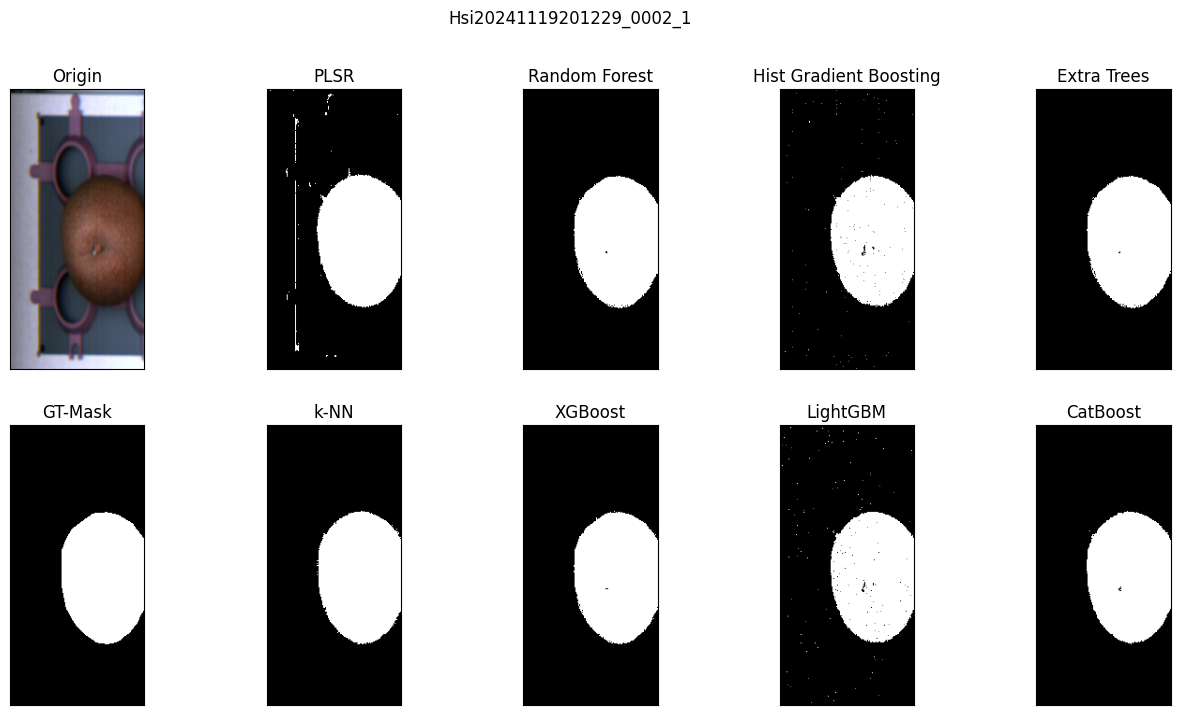

Hsi20241119201229_0002_2


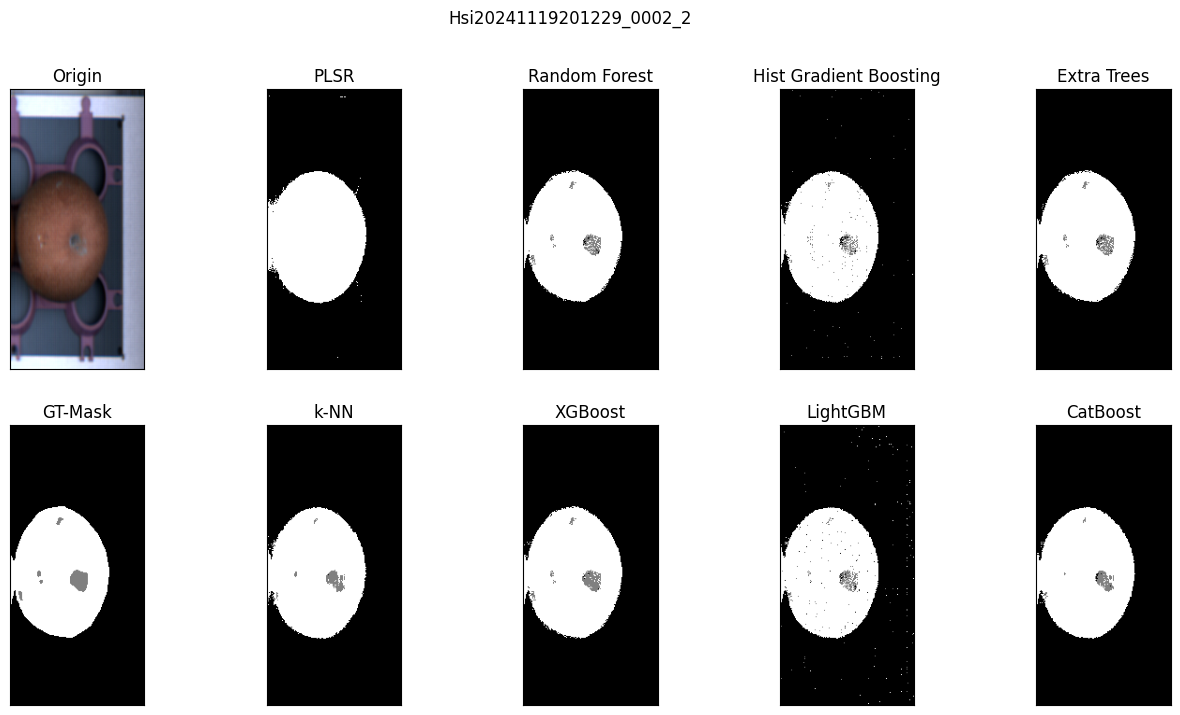

Hsi20241119201913_0003_1


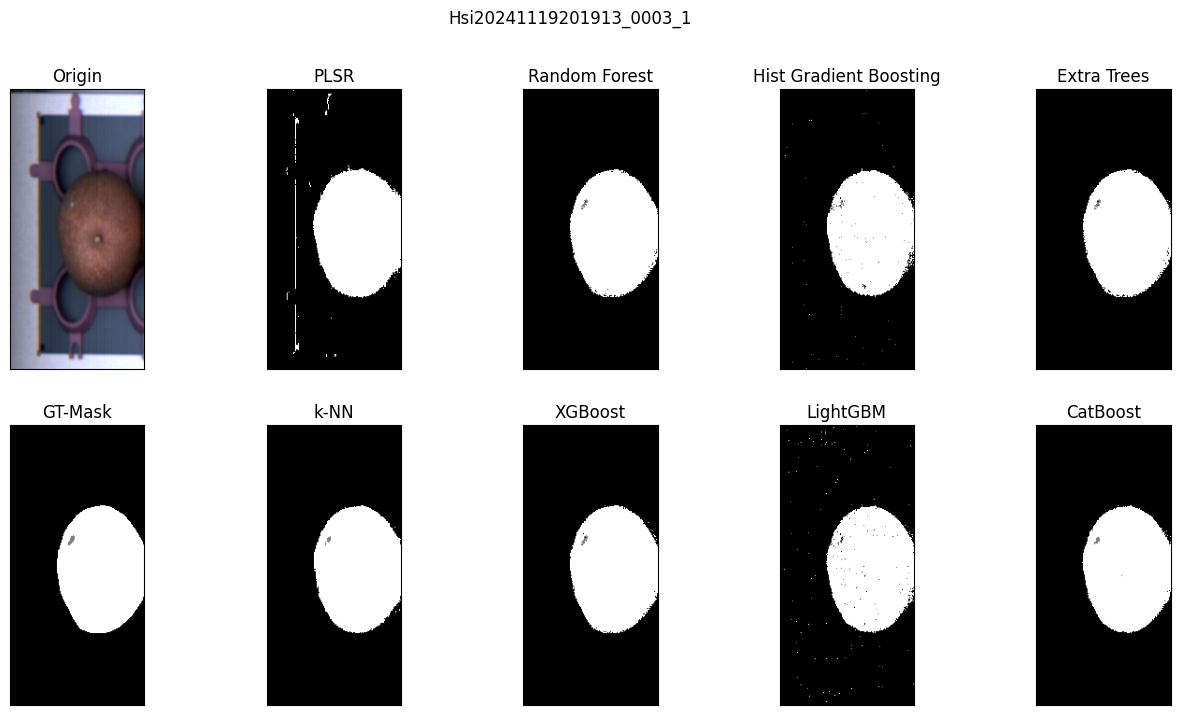

Hsi20241119201913_0003_2


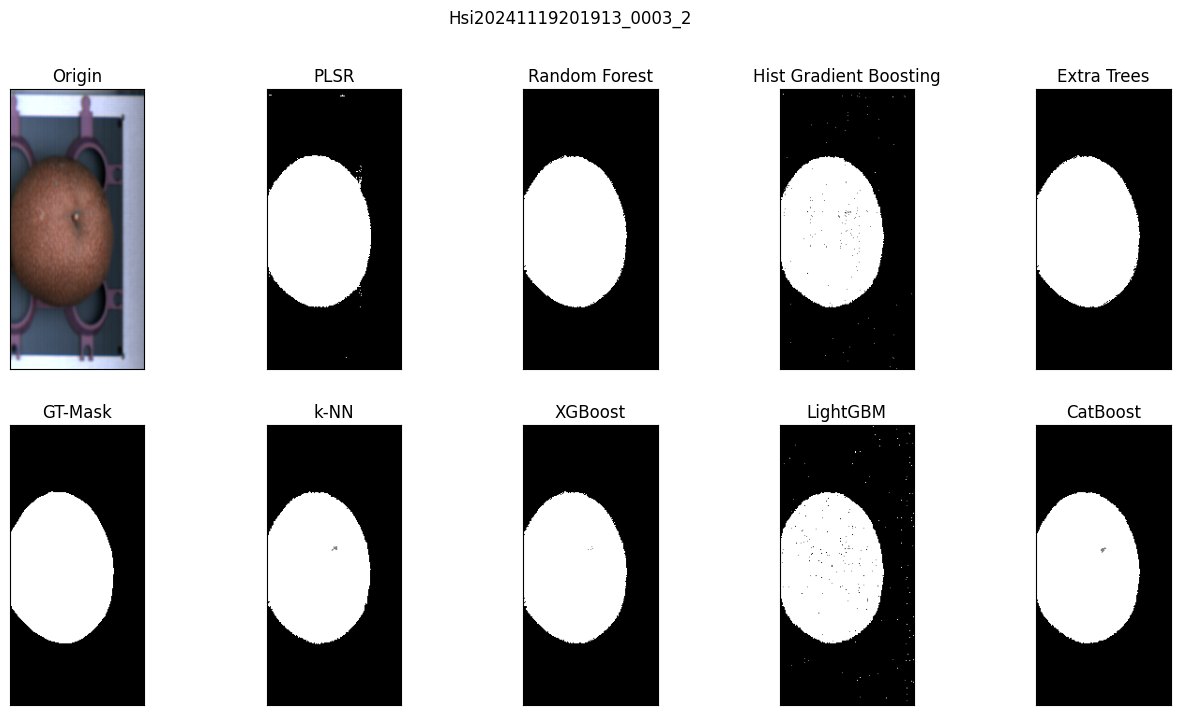

In [7]:
file_list = sorted([f for f in os.listdir(label_folder) if f.endswith('.png')])[:4]

for label_file in file_list:
    base_name = os.path.splitext(label_file)[0]
    hdr_path = os.path.join(hyperspectral_folder, base_name + '.hdr')
    raw_path = hdr_path.replace('.hdr', '.raw')
    label_path = os.path.join(label_folder, label_file)
    
    if not os.path.exists(hdr_path):
        continue
    
    # Load hyperspectral cube
    img = open_image(hdr_path)
    hyperspectral_cube = img.load()
    flattened_cube = hyperspectral_cube.reshape(-1, hyperspectral_cube.shape[-1])  # Shape: (96000, 256)
    preprocessed_cube = apply_differencing(apply_savgol_filter(flattened_cube))
    
    # Load corresponding label image
    label_img = Image.open(label_path).convert('L')

    print(base_name)

    plt.figure(figsize=(16, 8))
    plt.suptitle(base_name)

    plt.subplot(2, 5, 1)
    plt.title("Origin")
    rgb_image = generate_rgb_image(hyperspectral_cube)
    plt.imshow(rgb_image)

    plt.subplot(2, 5, 6)
    plt.title("GT-Mask")
    label_image = label_img.copy()
    plt.imshow(label_image, cmap='gray')

    # plt.subplot(2, 5, 2)
    # plt.title("Decision Tree")
    # model = joblib.load('./weights/Decision Tree_pear_model_compare.pkl')
    # pred_image = model.predict(preprocessed_cube).reshape(hyperspectral_cube.shape[:2])
    # plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 2)
    plt.title("PLSR")
    model = joblib.load('./weights/PLSR_pear_model_compare.pkl')
    pred_image = (model.predict(preprocessed_cube) > 0.5).astype(int).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 3)
    plt.title("Random Forest")
    model = joblib.load('./weights/Random Forest_pear_model_compare.pkl')
    pred_image = model.predict(preprocessed_cube).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 4)
    plt.title("Hist Gradient Boosting")
    model = joblib.load('./weights/Hist Gradient Boosting_pear_model_compare.pkl')
    pred_image = model.predict(preprocessed_cube).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 5)
    plt.title("Extra Trees")
    model = joblib.load('./weights/Extra Trees_pear_model_compare.pkl')
    pred_image = model.predict(preprocessed_cube).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 7)
    plt.title("k-NN")
    model = joblib.load('./weights/k-NN_pear_model_compare.pkl')
    pred_image = model.predict(preprocessed_cube).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 8)
    plt.title("XGBoost")
    model = joblib.load('./weights/XGBoost_pear_model_compare.pkl')
    pred_image = model.predict(preprocessed_cube).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 9)
    plt.title("LightGBM")
    model = joblib.load('./weights/LightGBM_pear_model_compare.pkl')
    pred_image = model.predict(preprocessed_cube).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 10)
    plt.title("CatBoost")
    model = joblib.load('./weights/CatBoost_pear_model_compare.pkl')
    pred_image = model.predict(preprocessed_cube).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    # 모든 subplot의 눈금을 제거
    for ax in plt.gcf().get_axes():
        ax.set_xticks([])
        ax.set_yticks([])

    plt.savefig(f'./OUTPUT/pear/model_test/{base_name}.png')
    plt.show()